# Part 5: World Happiness Regression Analysis

Models:
1.  Part 1: Simple Linear Regression
2.  Part 2: Multiple Linear Regression
3.  Part 3: Fixed Effects Model


In [10]:
# 1. Setup & Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from stargazer.stargazer import Stargazer

In [11]:
# 2. Load and Clean Data
df = pd.read_csv("happiness_clean_2015_2019_20251110_190504.csv")

# Define core variables
target = 'happiness_score'
predictors = [
    'gdp_per_capita',
    'social_support',
    'healthy_life_expectancy',
    'freedom',
    'generosity',
    'corruption'
]
all_vars = [target] + predictors + ['year', 'country']

# Drop NAs for a consistent sample
df_clean = df[all_vars].dropna().copy()

# Create Log-Transformed versions for later
df_clean['log_happiness'] = np.log(df_clean['happiness_score'])
df_clean['log_gdp'] = np.log(df_clean['gdp_per_capita'] + 1)
df_clean['gdp_sq'] = df_clean['gdp_per_capita'].pow(2)

## Part 1: Simple Linear Regression

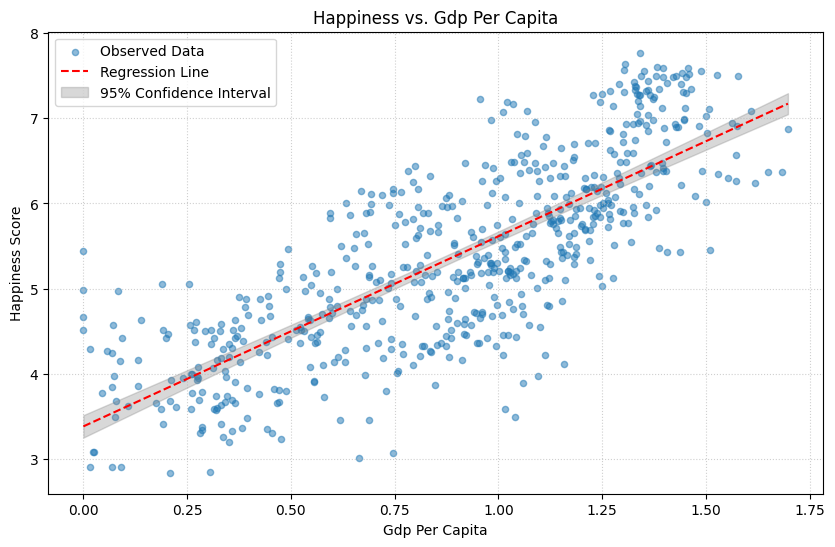

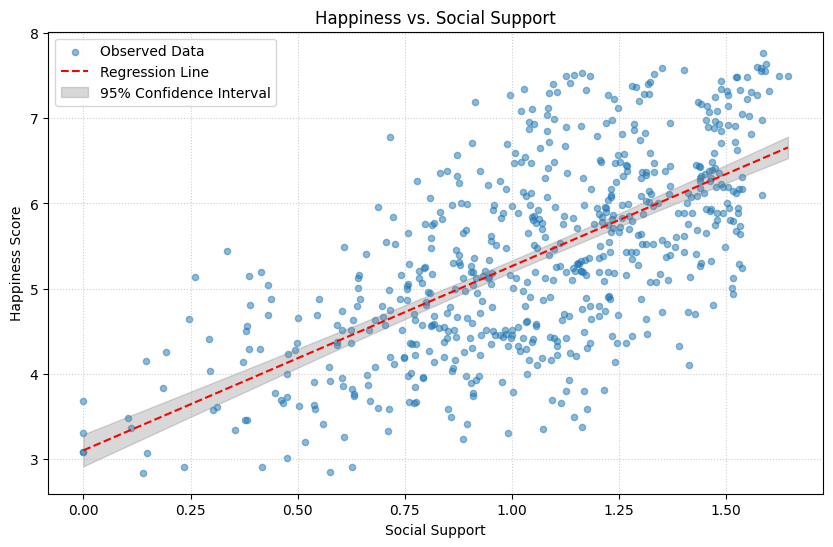

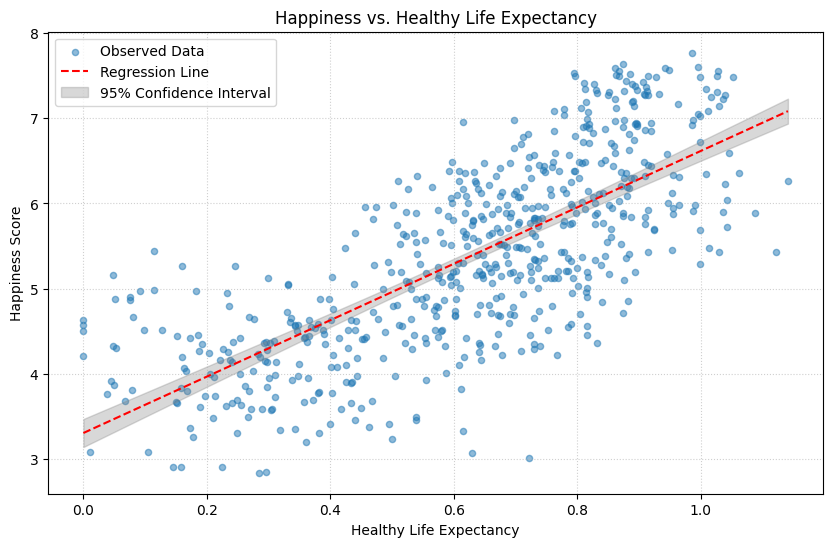

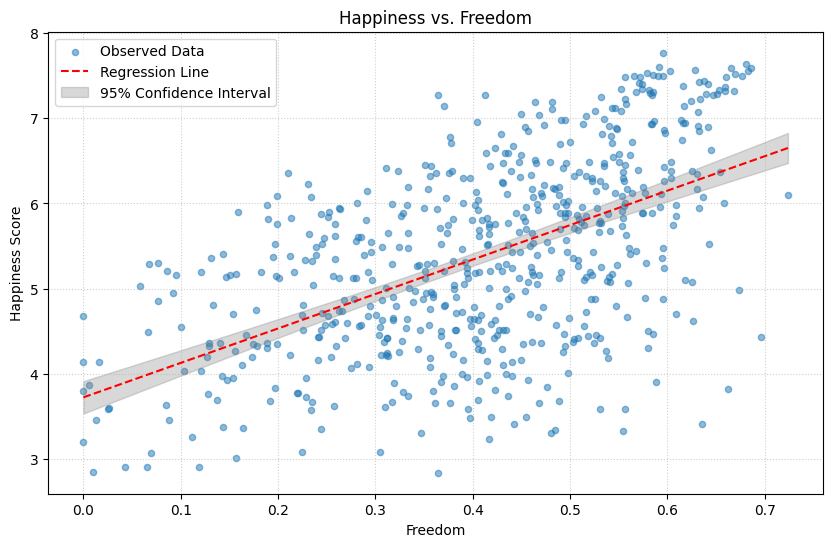

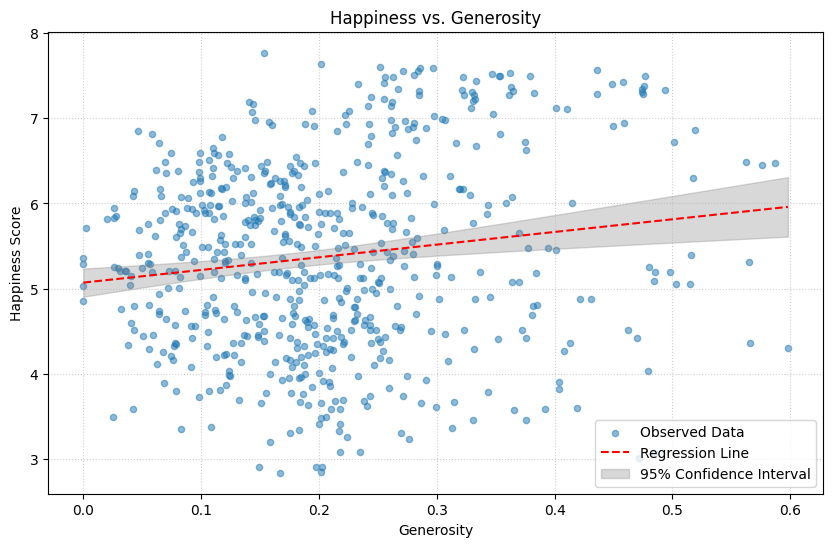

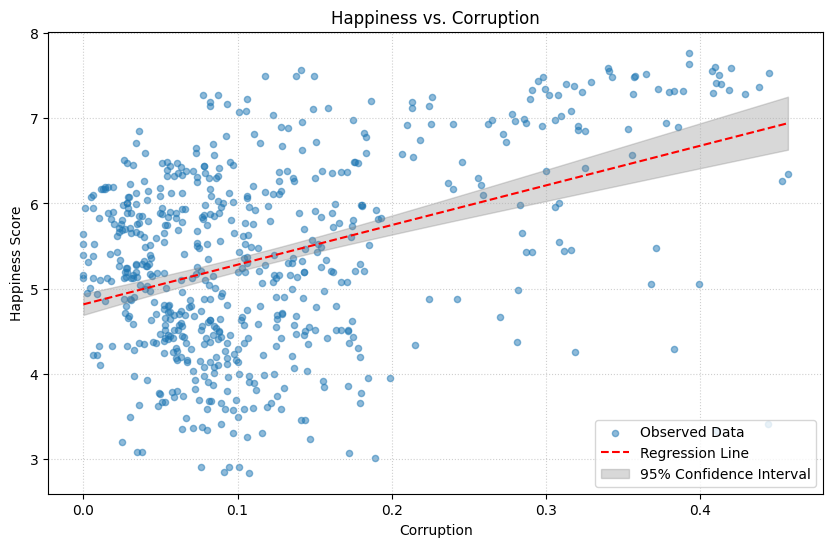

In [12]:
models_simple = {}

for pred in predictors:

    # 1. Fit Simple OLS Model
    y = df_clean['happiness_score']
    x = df_clean[pred]
    X = sm.add_constant(x)

    # Fit model with Robust Standard Errors
    model = sm.OLS(y, X).fit(cov_type='HC3')
    models_simple[pred] = model

    # 2. Get Prediction Intervals
    pred_CI = model.get_prediction(X).summary_frame(alpha=0.05)
    df_plot = df_clean.join(pred_CI)

    # 3. Sort by X-variable for a clean plot
    df_plot = df_plot.sort_values(by=pred)

    # 4. Plot Bivariate Model with 95% CI
    plt.figure(figsize=(10, 6))
    plt.scatter(df_plot[pred], df_plot['happiness_score'],
                label='Observed Data', alpha=0.5, s=20)
    plt.plot(df_plot[pred], df_plot['mean'],
             color='red', linestyle='--', label='Regression Line')
    plt.fill_between(df_plot[pred],
                     df_plot['mean_ci_lower'],
                     df_plot['mean_ci_upper'],
                     color='gray', alpha=0.3, label='95% Confidence Interval')

    plt.xlabel(pred.replace('_', ' ').title())
    plt.ylabel('Happiness Score')
    plt.title(f'Happiness vs. {pred.replace("_", " ").title()}')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

## Part 2: Multiple Linear Regression

1.  Base (Level-Level): happiness ~ gdp + other predictors
2.  Level-Log: happiness ~ log(gdp) + other predictors
3.  Log-Level: log(happiness) ~ gdp + other predictors
4.  Log-Log: log(happiness) ~ log(gdp) + other predictors
5.  Polynomial: happiness ~ gdp + gdp^2 + other predictors

In [13]:
# Define the base predictor strings
predictors_base = 'gdp_per_capita + social_support + healthy_life_expectancy + freedom + generosity + corruption'
predictors_log_gdp = 'log_gdp + social_support + healthy_life_expectancy + freedom + generosity + corruption'
predictors_poly = 'gdp_per_capita + gdp_sq + social_support + healthy_life_expectancy + freedom + generosity + corruption'

model_base = smf.ols(f"happiness_score ~ {predictors_base}", data=df_clean).fit(cov_type='HC3')
model_level_log = smf.ols(f"happiness_score ~ {predictors_log_gdp}", data=df_clean).fit(cov_type='HC3')
model_poly = smf.ols(f"happiness_score ~ {predictors_poly}", data=df_clean).fit(cov_type='HC3')

# Models with log(happiness) as the dependent variable
model_log_level = smf.ols(f"log_happiness ~ {predictors_base}", data=df_clean).fit(cov_type='HC3')
model_log_log = smf.ols(f"log_happiness ~ {predictors_log_gdp}", data=df_clean).fit(cov_type='HC3')

# Chart 1: Fitted Regression Lines (Linear vs. Polynomial)


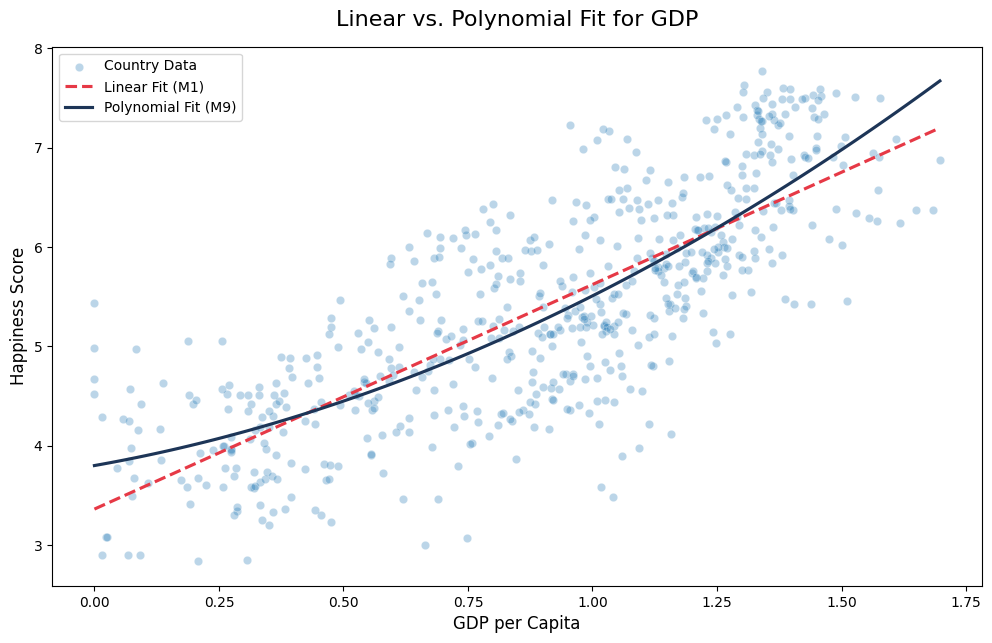

In [14]:
plt.figure(figsize=(12, 7))

# Plot the scatter plot of the raw data
sns.scatterplot(data=df_clean, x='gdp_per_capita', y='happiness_score', alpha=0.3, label='Country Data')

# 1. Plot the Linear Fit line (from M1)
sns.regplot(data=df_clean, x='gdp_per_capita', y='happiness_score',
            order=1, robust=True, ci=None, scatter=False,
            label='Linear Fit (M1)', line_kws={'linestyle':'--', 'color':'#E63946'})

# 2. Plot the Polynomial Fit line (from M9)
# We use order=2 to get the quadratic (gdp + gdp^2) curve
sns.regplot(data=df_clean, x='gdp_per_capita', y='happiness_score',
            order=2, ci=None, scatter=False,
            label='Polynomial Fit (M9)', line_kws={'linestyle':'-', 'color':'#1D3557'})

plt.title('Linear vs. Polynomial Fit for GDP', fontsize=16, pad=15)
plt.xlabel('GDP per Capita', fontsize=12)
plt.ylabel('Happiness Score', fontsize=12)
plt.legend()
plt.show()

## Part 3: Fixed Effects Models

Here we control for "Country" and "Year".

In [15]:
# We can use Robust SE for Year FE (low number of dummies)
model_fe_year = smf.ols(f"happiness_score ~ {predictors_base} + C(year)", data=df_clean).fit()
model_fe_country = smf.ols(f"happiness_score ~ {predictors_base} + C(country)", data=df_clean).fit()
model_fe_twoway = smf.ols(f"happiness_score ~ {predictors_base} + C(year) + C(country)", data=df_clean).fit()

Model 3 (Fixed Effects) models fitted successfully.


# Chart 2: Coefficient Comparison Plot (M7 vs. M13)

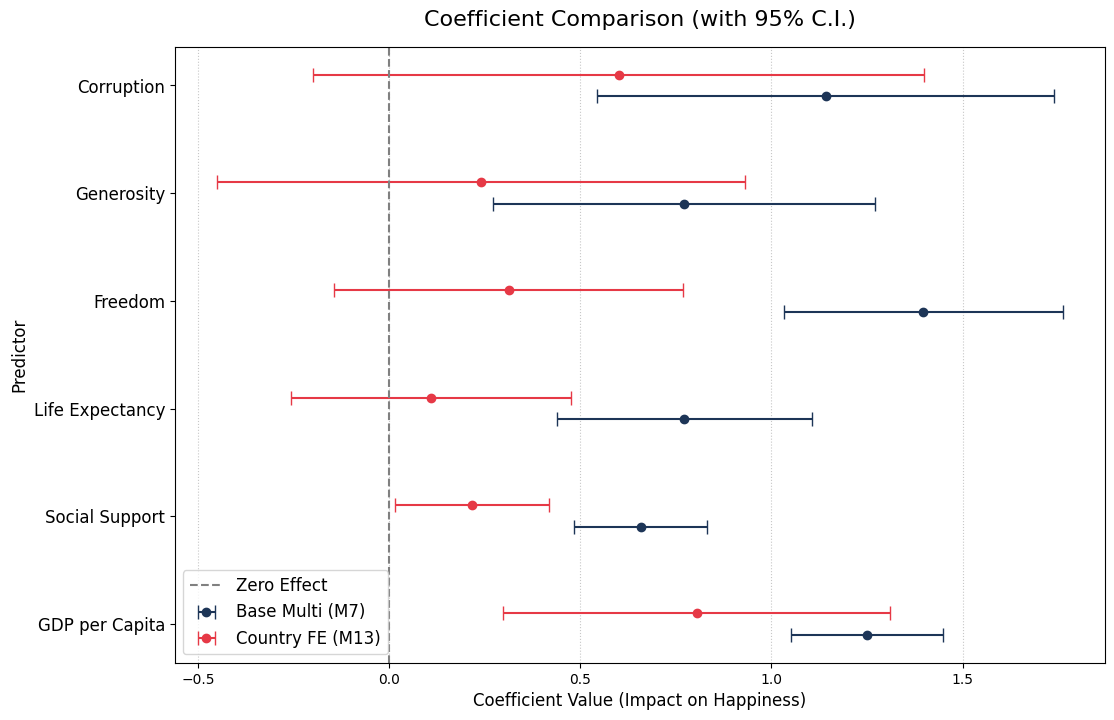

In [16]:
# Get the list of predictors
predictors = [
    'gdp_per_capita',
    'social_support',
    'healthy_life_expectancy',
    'freedom',
    'generosity',
    'corruption'
]

# Create a clean DataFrame for plotting
def get_coef_df(model, model_name, predictors):
    params = model.params.filter(items=predictors)
    conf = model.conf_int().filter(items=predictors, axis=0)
    conf['param'] = params
    conf['err'] = params - conf[0] # Calculate error margin
    conf = conf.reset_index().rename(columns={'index': 'predictor', 0: 'ci_lower', 1: 'ci_upper'})
    conf['model'] = model_name
    return conf

# Get data for both models
df_m7 = get_coef_df(model_base, 'Base Multi (M7)', predictors)
df_m13 = get_coef_df(model_fe_country, 'Country FE (M13)', predictors)

# Combine them
plot_df = pd.concat([df_m7, df_m13])

# Rename for nicer plot labels
plot_df['predictor'] = plot_df['predictor'].replace({
    'gdp_per_capita': 'GDP per Capita',
    'social_support': 'Social Support',
    'healthy_life_expectancy': 'Life Expectancy',
    'freedom': 'Freedom',
    'generosity': 'Generosity',
    'corruption': 'Corruption'
})

# Plot using plt.errorbar for clarity
plt.figure(figsize=(12, 8))
y = np.arange(len(predictors))
predictor_labels = plot_df['predictor'].unique()

# Plot M7
m7_data = plot_df[plot_df['model'] == 'Base Multi (M7)']
plt.errorbar(x=m7_data['param'], y=y - 0.1, xerr=m7_data['err'],
             label='Base Multi (M7)', fmt='o', capsize=5, color='#1D3557')

# Plot M13
m13_data = plot_df[plot_df['model'] == 'Country FE (M13)']
plt.errorbar(x=m13_data['param'], y=y + 0.1, xerr=m13_data['err'],
             label='Country FE (M13)', fmt='o', capsize=5, color='#E63946')

plt.axvline(0, linestyle='--', color='grey', label='Zero Effect')
plt.yticks(y, labels=predictor_labels, fontsize=12)
plt.title('Coefficient Comparison (with 95% C.I.)', fontsize=16, pad=15)
plt.xlabel('Coefficient Value (Impact on Happiness)', fontsize=12)
plt.ylabel('Predictor', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.show()

# Chart 3: R-squared Comparison Plot

/tmp/ipython-input-1793948600.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=r_squared_series.index, y=r_squared_series.values, palette="Blues_r")


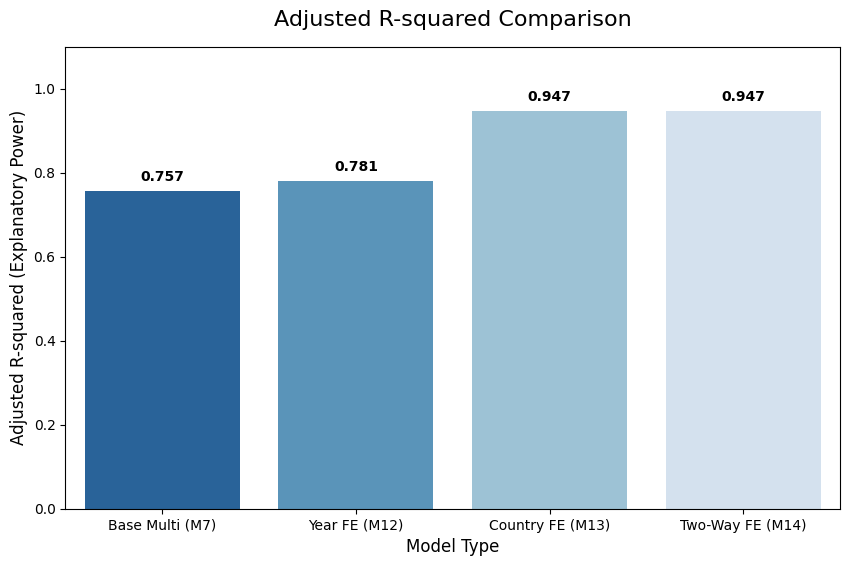

In [21]:
r_squared_data = {
    'Base Multi (M7)': model_base.rsquared_adj,
    'Year FE (M12)': model_fe_year.rsquared_adj,
    'Country FE (M13)': model_fe_country.rsquared_adj,
    'Two-Way FE (M14)': model_fe_twoway.rsquared_adj
}

# Convert to a Series for easy plotting
r_squared_series = pd.Series(r_squared_data, name="Adjusted R²")
r_squared_series.index.name = "Model"

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=r_squared_series.index, y=r_squared_series.values, palette="Blues_r")
ax.set_ylim(0, 1.1) # Set y-axis from 0 to 1.1 to give text labels space

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontweight='bold')

plt.title('Adjusted R-squared Comparison', fontsize=16, pad=15)
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('Adjusted R-squared (Explanatory Power)', fontsize=12)
plt.show()

# Phase 5 Conclusion: Comparison Table

We use Stargazer to present all key models in one table.

In [19]:
if not df_clean.empty:
    # 1. Create the Stargazer object with ALL fitted models
    all_fitted_models = (
        [models_simple[pred] for pred in predictors] +
        [
            model_base,
            model_level_log,
            model_poly,
            model_log_level,
            model_log_log,
            model_fe_year,
            model_fe_country,
            model_fe_twoway
        ]
    )

    stargazer = Stargazer(all_fitted_models)

    # 2. Customize the table

    # Create matching column labels
    column_labels = [
        'Simple GDP', 'Simple Social', 'Simple Life', 'Simple Freedom', 'Simple Generosity', 'Simple Corruption',
        'Base Multi', 'Level-Log', 'Poly', 'Log-Level', 'Log-Log',
        'Year FE', 'Country FE', 'Two-Way FE'
    ]
    stargazer.custom_columns(column_labels, [1] * len(column_labels))

    stargazer.significance_levels([0.1, 0.05, 0.01])
    stargazer.show_degrees_of_freedom(False)

    # Rename variables for clarity
    stargazer.rename_covariates({
        'gdp_per_capita': 'GDP per Capita',
        'social_support': 'Social Support',
        'healthy_life_expectancy': 'Life Expectancy',
        'freedom': 'Freedom',
        'generosity': 'Generosity',
        'corruption': 'Corruption',
        'log_gdp': 'Log(GDP)',
        'gdp_sq': 'GDP Squared',
        'Intercept': 'Constant'
    })

    # Order & hide FE dummies (by only listing the ones we want)
    stargazer.covariate_order([
        'gdp_per_capita', 'log_gdp', 'gdp_sq',
        'social_support', 'healthy_life_expectancy',
        'freedom', 'generosity', 'corruption', 'Intercept'
    ])

    # Add custom lines to clarify what's in each model
    fe_line = [
        'No', 'No', 'No', 'No', 'No', 'No', # Simple models
        'No', 'No', 'No', 'No', 'No', # Multi/Transformed
        'Year', 'Country', 'Year + Country' # FE Models
    ]
    stargazer.add_line('Fixed Effects', fe_line)

    # Clarify which models predict log(happiness)
    dep_var_line = [
        'Level', 'Level', 'Level', 'Level', 'Level', 'Level', # Simple
        'Level', 'Level', 'Level', 'Log', 'Log', # Multi/Transformed
        'Level', 'Level', 'Level' # FE
    ]
    stargazer.add_line('Dep. Var (Y)', dep_var_line)


    # 3. Render the HTML and save to a file
    html_output = stargazer.render_html()
    output_filename = "model_comparison_table.html"

    with open(output_filename, "w") as f:
        f.write(html_output)

stargazer